In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, classification_report
import numpy as np
import seaborn as sns
import time


This notebook serializes the method for data preprocessing, training and evaluation of the models. The code below this block Defines the Data preprocessing procedure, the training procedure and evaluation code. All the models utilize the same functions for obtaining the output. Please run all the blocks to successfully traing and evaluate the models.

Data Preprocessing:
-Changing the dataset to Tensor
-Normalizing the dataset
-Importing the dataset using CIFAR10 from torch
-Using Subset from torch to make subset of the data for 500 images per class for training and 100 for testing
-Making dataloaders to set the batch size for training and testing

Training:
-Training all the models for 100 epochs
-Cross Entropy Loss function for all models
-Optmizer is SGD with learning rate 0.01 and momentum of 0.9

Evaluation:
-We use sickit learn for calculating the metrics
-The function evaluate model prints the metrics for all the models


In [6]:
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize


])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to limit dataset to the first N images per class
def get_limited_dataset(dataset, n_per_class):
    class_indices = {i: 0 for i in range(10)}  # Counter for each class
    limited_indices = []

    for idx, (_, label) in enumerate(dataset):
        if class_indices[label] < n_per_class:
            limited_indices.append(idx)
            class_indices[label] += 1
        if all(count == n_per_class for count in class_indices.values()):
            break

    return Subset(dataset, limited_indices)
# Get 500 training and 100 test images per class
train_subset = get_limited_dataset(train_dataset, 500)
test_subset = get_limited_dataset(test_dataset, 100)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100
#training and testing is performed together to see the learning procedure of the models
def train_test(model, num_epochs):
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    # Testing loop
    #calculating Testing while training to stop early if the model is not learning
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    training_loss_list.append(avg_train_loss)
    # Testing loop
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            # Calculate test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Calculate test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    test_loss_list.append(avg_test_loss)


def evaluate_model(model):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)


    avg_test_loss = test_loss / len(test_loader)
    class_report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # Print the results
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Classification Report:\n{class_report}")





100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Base case below:

Training time: 414.65465569496155 seconds


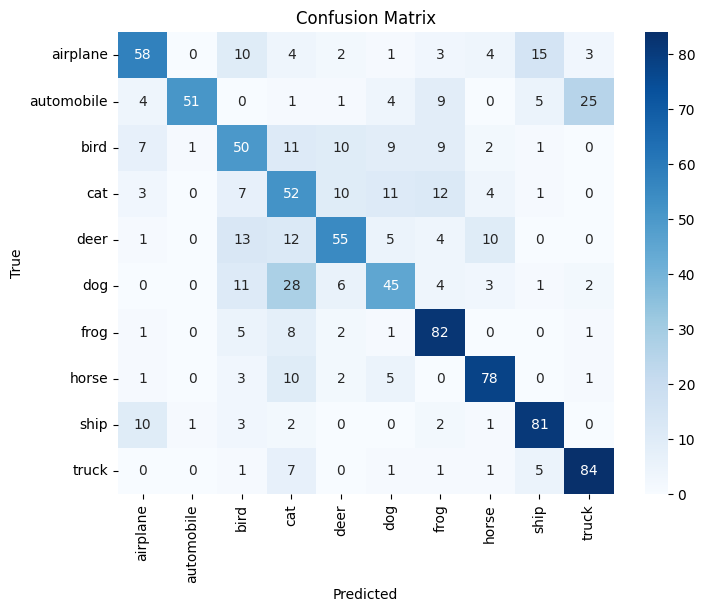

In [7]:

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            #Convolutional layers for extracting features from the data
            #Batch Normalization for more noise and to help in extraction
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            #Classification layers
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.classifier(x)
        return x

model = VGG11()


training_loss_list = []
test_loss_list = []
#record training time and run the program for 100 epochs
start_time = time.time()
train_test(model, num_epochs=100)
end_time = time.time()
#saving the model, commented out for the markers to edit the location of file
#torch.save(model.state_dict(), '/content/drive/MyDrive/Models/vgg11_base.pth')
print(f"Training time: {end_time - start_time} seconds")
#metrics
metrics = evaluate_model(model)




Extra Convolutional layers

Test Accuracy: 63.60%
Test Loss: 83.6838
Precision: 0.6564
Recall: 0.6360
F1-Score: 0.6356
Classification Report:
              precision    recall  f1-score   support

    airplane       0.68      0.58      0.63       100
  automobile       0.96      0.51      0.67       100
        bird       0.49      0.50      0.49       100
         cat       0.39      0.52      0.44       100
        deer       0.62      0.55      0.59       100
         dog       0.55      0.45      0.49       100
        frog       0.65      0.82      0.73       100
       horse       0.76      0.78      0.77       100
        ship       0.74      0.81      0.78       100
       truck       0.72      0.84      0.78       100

    accuracy                           0.64      1000
   macro avg       0.66      0.64      0.64      1000
weighted avg       0.66      0.64      0.64      1000

VGG11_AddConv(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Bat

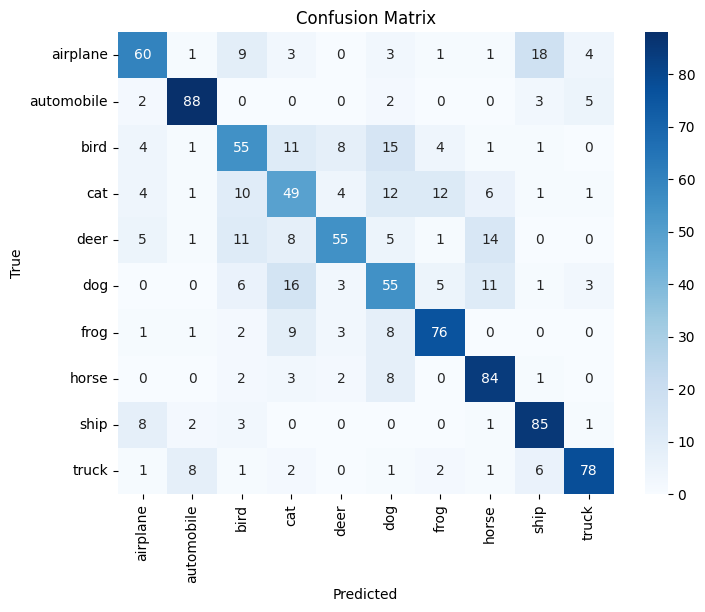

Test Accuracy: 68.50%
Test Loss: 63.3576
Precision: 0.6878
Recall: 0.6850
F1-Score: 0.6834
Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.60      0.65       100
  automobile       0.85      0.88      0.87       100
        bird       0.56      0.55      0.55       100
         cat       0.49      0.49      0.49       100
        deer       0.73      0.55      0.63       100
         dog       0.50      0.55      0.53       100
        frog       0.75      0.76      0.76       100
       horse       0.71      0.84      0.77       100
        ship       0.73      0.85      0.79       100
       truck       0.85      0.78      0.81       100

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.68      1000
weighted avg       0.69      0.69      0.68      1000



In [8]:
class VGG11_AddConv(nn.Module):
    def __init__(self):
        super(VGG11_AddConv, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
model = VGG11_AddConv()
print(model)



training_loss_list = []
test_loss_list = []
start_time = time.time()

train_test(model, num_epochs=100)
end_time = time.time()
#saving the model, commented out for the markers to edit the location of file
#torch.save(model.state_dict(), '/content/drive/MyDrive/Models/vgg11_extra_layer2.pth')
print(f"Training time: {end_time - start_time} seconds")
metrics = evaluate_model(model)



Two Less Convolutional layer

VGG11LessLayer2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): 

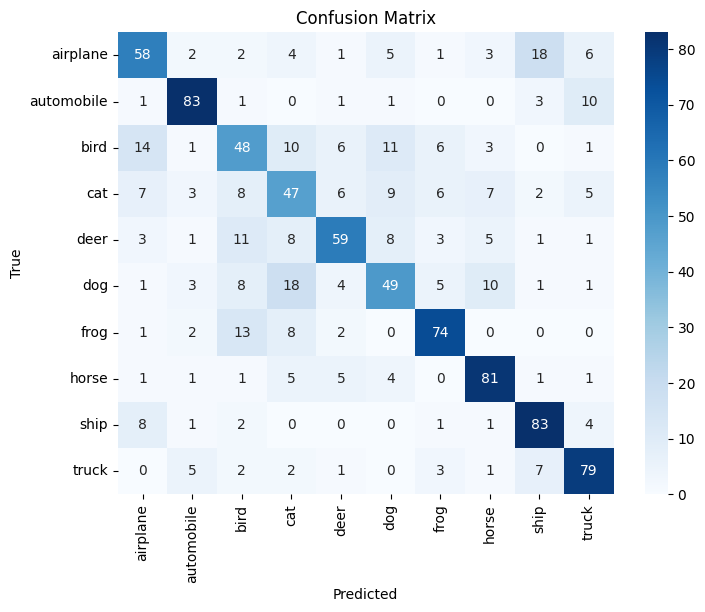

Test Accuracy: 66.10%
Test Loss: 72.9080
Precision: 0.6573
Recall: 0.6610
F1-Score: 0.6576
Classification Report:
              precision    recall  f1-score   support

    airplane       0.62      0.58      0.60       100
  automobile       0.81      0.83      0.82       100
        bird       0.50      0.48      0.49       100
         cat       0.46      0.47      0.47       100
        deer       0.69      0.59      0.64       100
         dog       0.56      0.49      0.52       100
        frog       0.75      0.74      0.74       100
       horse       0.73      0.81      0.77       100
        ship       0.72      0.83      0.77       100
       truck       0.73      0.79      0.76       100

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



In [9]:
#Two layers were removed from the basic VGG11 model
# The layers are commented to highlight the ones removed
class VGG11LessLayer2(nn.Module):
    def __init__(self):
        super(VGG11LessLayer2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            #nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(512),
            #nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(512),
            #nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.classifier(x)
        return x






model = VGG11LessLayer2()
print(model)
training_loss_list = []
test_loss_list = []

start_time = time.time()
train_test(model, num_epochs=100)
end_time = time.time()

#saving the model, commented out for the markers to edit the location of file
#torch.save(model.state_dict(), '/content/drive/MyDrive/Models/vgg11_less_layer2.pth')

print(f"Training time: {end_time - start_time} seconds")

metrics = evaluate_model(model)

Kernel size = 2

VGG11Kernel2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Max

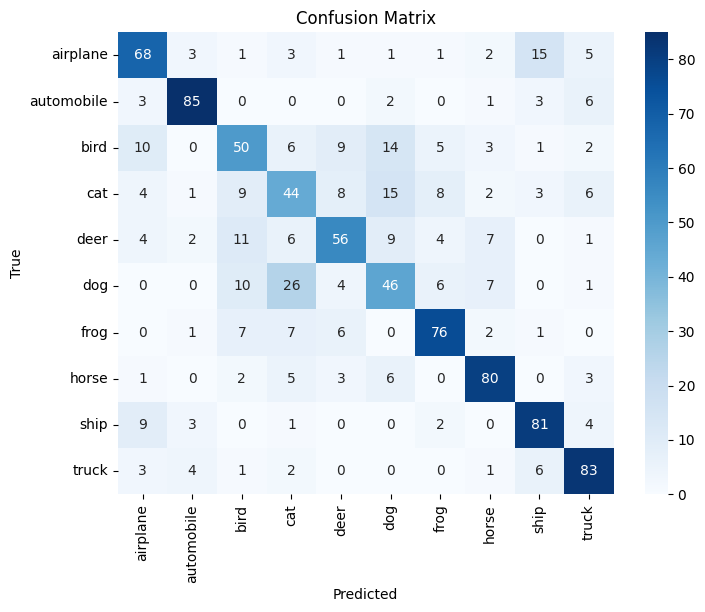

Test Accuracy: 66.90%
Test Loss: 79.4865
Precision: 0.6644
Recall: 0.6690
F1-Score: 0.6658
Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.68      0.67       100
  automobile       0.86      0.85      0.85       100
        bird       0.55      0.50      0.52       100
         cat       0.44      0.44      0.44       100
        deer       0.64      0.56      0.60       100
         dog       0.49      0.46      0.48       100
        frog       0.75      0.76      0.75       100
       horse       0.76      0.80      0.78       100
        ship       0.74      0.81      0.77       100
       truck       0.75      0.83      0.79       100

    accuracy                           0.67      1000
   macro avg       0.66      0.67      0.67      1000
weighted avg       0.66      0.67      0.67      1000



In [10]:

class VGG11Kernel2(nn.Module):
    def __init__(self):
        super(VGG11Kernel2, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG11Kernel2()
print(model)

training_loss_list = []
test_loss_list = []

start_time = time.time()
train_test(model, num_epochs=100)
end_time = time.time()

#saving the model, commented out for the markers to edit the location of file
#torch.save(model.state_dict(), '/content/drive/MyDrive/Models/vgg11_Kernel2.pth')
print(f"Training time: {end_time - start_time} seconds")

metrics = evaluate_model(model)

Bigger Kernel Size: 5

VGG11Kernel5(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Max

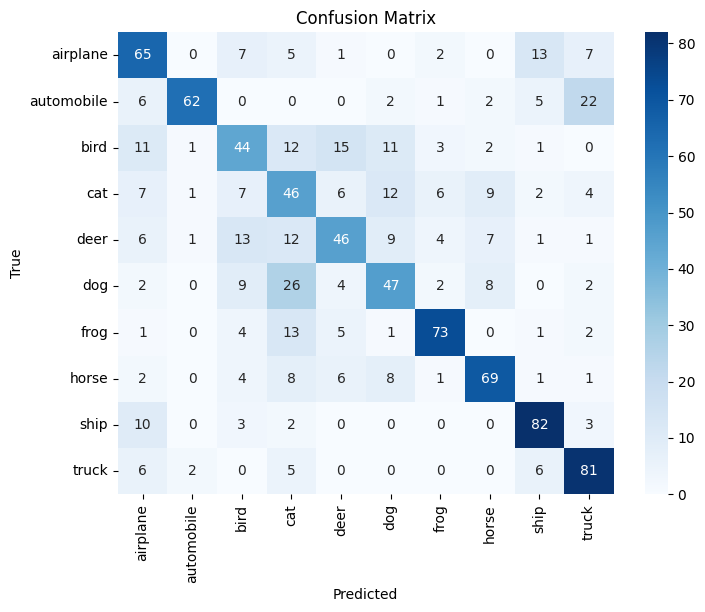

Test Accuracy: 61.50%
Test Loss: 76.4289
Precision: 0.6298
Recall: 0.6150
F1-Score: 0.6165
Classification Report:
              precision    recall  f1-score   support

    airplane       0.56      0.65      0.60       100
  automobile       0.93      0.62      0.74       100
        bird       0.48      0.44      0.46       100
         cat       0.36      0.46      0.40       100
        deer       0.55      0.46      0.50       100
         dog       0.52      0.47      0.49       100
        frog       0.79      0.73      0.76       100
       horse       0.71      0.69      0.70       100
        ship       0.73      0.82      0.77       100
       truck       0.66      0.81      0.73       100

    accuracy                           0.61      1000
   macro avg       0.63      0.61      0.62      1000
weighted avg       0.63      0.61      0.62      1000



In [11]:
#for Kernel with size 5 padding was added to process the data with a bigger kernel.
class VGG11Kernel5(nn.Module):
    def __init__(self):
        super(VGG11Kernel5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),  # Adjust based on the flattened size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x






model = VGG11Kernel5()
print(model)

training_loss_list = []
test_loss_list = []
start_time = time.time()

train_test(model, num_epochs=100)
end_time = time.time()
#saving the model, commented out for the markers to edit the location of file
#torch.save(model.state_dict(), '/content/drive/MyDrive/Models/vgg11_kernel5.pth')

print(f"Training time: {end_time - start_time} seconds")

metrics = evaluate_model(model)

